In [1]:
!pip install torch torchvision torchaudio pennylane cotengra quimb torchmetrics --upgrade

In [2]:
# Import packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import numpy as np

import pandas as pd
from sklearn import datasets
import seaborn as sns

import time

import functools

from typing import List, Union, Tuple, Dict, Optional, Any
from typing import Callable



import torch 
import torchvision 




import pennylane as qml
import pennylane.numpy as pnp

import os, cv2, itertools # cv2 -- OpenCV
import shutil
import zipfile
%matplotlib inline




sns.set()

seed = 1701
rng = np.random.default_rng(seed=seed)
prng = pnp.random.default_rng(seed=seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

torch.set_default_dtype(torch.double)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#COMPLEX_DTYPE = torch.cfloat #torch.cdouble
#REAL_DTYPE = torch.float

print(device)

cuda


In [3]:
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Pad(2),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,)),
    #torchvision.transforms.Lambda(lambda x: x.type(COMPLEX_DTYPE))
])

train_dataset = torchvision.datasets.FashionMNIST(
    "FashionMNIST",
    train=True,
    download=True,
    transform=preprocess,
)
test_dataset = torchvision.datasets.FashionMNIST(
    "FashionMNIST",
    train=False,
    download=True,
    transform=preprocess,
)
dummy_trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True
)
dummy_testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=True
)

dummy_x, dummy_y = next(iter(dummy_trainloader))

print(dummy_x.shape)  # 64x32x32
print(dummy_y.shape)  # 64
print(dummy_y)
print(dummy_x[0,0,16])

torch.Size([64, 1, 32, 32])
torch.Size([64])
tensor([4, 1, 7, 3, 5, 8, 2, 6, 4, 6, 6, 3, 6, 9, 9, 7, 8, 7, 7, 7, 2, 7, 3, 8,
        8, 8, 2, 2, 8, 2, 1, 5, 8, 7, 8, 2, 1, 4, 8, 7, 0, 0, 8, 9, 7, 5, 3, 6,
        9, 3, 9, 8, 7, 1, 8, 8, 0, 7, 3, 0, 6, 4, 5, 8])
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  0.7176,
         0.5686,  0.8588,  0.2235,  0.0902,  0.9059,  0.5529,  0.6000,  0.6078,
         0.6392,  0.6314,  0.6157,  0.8039,  0.4039, -0.0039,  0.9922,  0.6314,
         0.7490, -0.6235, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000])


In [4]:
class SimpleNet(torch.nn.Module):
  def __init__(self):
    super(SimpleNet, self).__init__()

    self.layers = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, kernel_size=3),
        torch.nn.Conv2d(32, 16, kernel_size=3),
        torch.nn.Flatten(),
        torch.nn.Linear(16*28*28, 10),
    )

  def forward(self, x):
    return self.layers(x)

net = SimpleNet().to(device)
test_img = dummy_x.to(device)
print(test_img.shape)
print(net)
test_out = net(test_img)
print(test_out.shape)

torch.Size([64, 1, 32, 32])
SimpleNet(
  (layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=12544, out_features=10, bias=True)
  )
)
torch.Size([64, 10])


In [5]:
import torchmetrics

BATCH_SIZE = 200
LEARNING_RATE = 3e-4
STEPS = 100
PRINT_EVERY_PERCENT = 0.2

def train(
    model,
    optim=torch.optim.SGD,
    criterion=torch.nn.CrossEntropyLoss,
    accuracy = torchmetrics.Accuracy,
    steps = 100,
    print_every_percent=0.1,
    batchsize = 100,
    lr = 0.001,
    device=torch.device("cpu")
):
  trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batchsize, shuffle=True
  )
  testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batchsize, shuffle=True
  )

  n_train_batches = len(trainloader)
  n_test_batches = len(testloader)
  print_every_train_batch = int(n_train_batches*print_every_percent)
  print_every_test_batch = int(n_test_batches*print_every_percent)

  print(f"Number of train batches = {n_train_batches}, Number of test batches = {n_test_batches}")
  print(f"Print every train batch = {print_every_train_batch}, Print every test batch = {print_every_test_batch}")

  model.to(device)
  optimizer = optim(model.parameters(), lr=lr, momentum=0.9)
  loss = criterion()
  acc_func = accuracy(task="multiclass", num_classes=10).to(device)
  step_train_losses = []
  step_test_losses = []
  step_train_accs = []
  step_test_accs = []
  for i in range(steps):
    step_start = time.time()
    batch_train_loss = []
    batch_train_acc = []
    batch_test_loss = []
    batch_test_acc = []
    # train
    model.train()
    for batchid, (images, labels) in enumerate(trainloader):
      batch_start = time.time()
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      train_loss = loss(outputs, labels)
      train_loss.backward()
      optimizer.step()
      train_acc = acc_func(outputs, labels)
      batch_train_loss.append(train_loss.item())
      batch_train_acc.append(train_acc.item())
      batch_finish = time.time()

      if (batchid) % print_every_train_batch == 0:
        print(f"Training at step={i}, batch={batchid}, train loss = {train_loss.item()}, train acc = {train_acc.item()}, time = {batch_finish-batch_start}")

    # eval
    model.eval()
    with torch.no_grad():
      for batchid, (images, labels) in enumerate(testloader):
        batch_start = time.time()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_loss = loss(outputs, labels)
        test_acc = acc_func(outputs, labels)
        batch_test_loss.append(test_loss.item())
        batch_test_acc.append(test_acc.item())
        batch_finish = time.time()
        if (batchid) % print_every_test_batch == 0:
          print(f"Testing at step={i}, batch={batchid}, test loss = {test_loss.item()}, test acc = {test_acc.item()}, time = {batch_finish-batch_start}")

    step_train_losses.append(np.mean(batch_train_loss))
    step_test_losses.append(np.mean(batch_test_loss))
    step_train_accs.append(np.mean(batch_train_acc))
    step_test_accs.append(np.mean(batch_test_acc))
    step_finish = time.time()
    print(f"Step {i} finished in {step_finish-step_start}, Train loss = {step_train_losses[-1]}, Test loss = {step_test_losses[-1]}; Train Acc = {step_train_accs[-1]}, Test Acc = {step_test_accs[-1]}")

  return step_train_losses, step_test_losses, step_train_accs, step_test_accs

train_losses, test_losses, train_accs, test_accs = train(net,
                                                        optim=torch.optim.SGD,
                                                        criterion=torch.nn.CrossEntropyLoss,
                                                        accuracy = torchmetrics.Accuracy,
                                                        steps = STEPS,
                                                        print_every_percent=PRINT_EVERY_PERCENT,
                                                        batchsize = BATCH_SIZE,
                                                        lr = LEARNING_RATE,
                                                        device=device)

Number of train batches = 300, Number of test batches = 50
Print every train batch = 60, Print every test batch = 10
Training at step=0, batch=0, train loss = 2.316196049109083, train acc = 0.09000000357627869, time = 0.18616652488708496
Training at step=0, batch=60, train loss = 1.007979989933517, train acc = 0.7099999785423279, time = 0.015845060348510742
Training at step=0, batch=120, train loss = 0.8442076010983364, train acc = 0.7049999833106995, time = 0.013129234313964844
Training at step=0, batch=180, train loss = 0.5252823933986468, train acc = 0.8349999785423279, time = 0.013153314590454102
Training at step=0, batch=240, train loss = 0.5198326100893944, train acc = 0.8299999833106995, time = 0.013137340545654297
Testing at step=0, batch=0, test loss = 0.6626033837997689, test acc = 0.7549999952316284, time = 0.0024709701538085938
Testing at step=0, batch=10, test loss = 0.6499353674216475, test acc = 0.7699999809265137, time = 0.002407073974609375
Testing at step=0, batch=20,

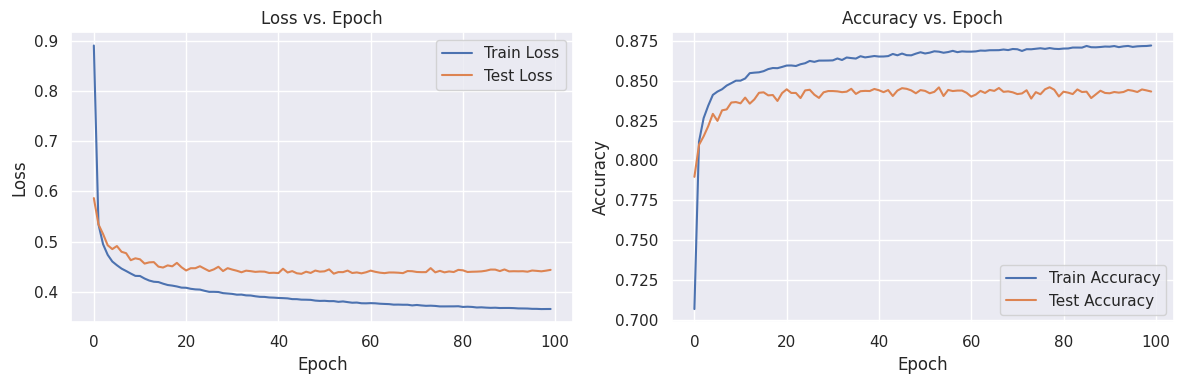

In [6]:
# plot

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the losses
ax1.plot(train_losses, label='Train Loss')
ax1.plot(test_losses, label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss vs. Epoch')
ax1.legend()

# Plot the accuracies
ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(test_accs, label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy vs. Epoch')
ax2.legend()

# Adjust the spacing between subplots
plt.tight_layout()
plt.savefig("0-fashionmnist_simple_cnn.pdf")
# Display the plots
plt.show()

In [7]:
import json

res_dict = {
    "train_losses": train_losses,
    "test_losses": test_losses,
    "train_accs": train_accs,
    "test_accs": test_accs
}

with open("0-fashionmnist_simple_cnn.json", "w") as f:
    json.dump(res_dict, f)